In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [ ]:
from einops import rearrange
import math
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from bliss.encoders.detection import DetectionEncoder
from bliss.catalog import TileCatalog, FullCatalog

import sep 
from bliss.datasets.lsst import BACKGROUND

from torch import Tensor

from bliss.reporting import compute_tp_fp_per_bin

from bliss.datasets.lsst import convert_flux_to_mag, get_default_lsst_psf, get_default_lsst_background

from einops import rearrange

from bliss.datasets.generate_blends import render_full_catalog

In [ ]:
from bliss.reporting import get_deblended_reconstructions, get_residual_measurements


In [ ]:
device = torch.device("cuda:0")


In [ ]:
# model
detection = DetectionEncoder().to(device).eval()
_ = detection.load_state_dict(
    torch.load(f"../../models/detection_23_23.pt", map_location=device, weights_only=True)
)
detection = detection.requires_grad_(False)

In [ ]:
# now use deblender to obtain reconstructions  and corresponding aperture photometry (for each sample!)
from bliss.encoders.deblend import GalaxyEncoder
deblend_fpath = "../../models/deblender_23_22.pt"
ae_fpath = "../../models/autoencoder_42_42.pt"

deblender = GalaxyEncoder(ae_fpath)
deblender.load_state_dict(torch.load(deblend_fpath, map_location=device, weights_only=True))
deblender = deblender.requires_grad_(False).to(device)

In [ ]:
slen = 55
bp = detection.bp
tile_slen = detection.tile_slen
size = slen + 2 * bp
tile_slen = detection.tile_slen
ptile_slen = detection.ptile_slen
assert slen / tile_slen % 2 == 1, "Need odd number of tiles to center galaxy."


In [ ]:

# now separations between galaxies to be considered (in pixels)
# for efficiency, we set the batch_size equal to the number of separations
seps = torch.arange(0, 20, 0.1)
batch_size = len(seps)

# first centered galaxy, then moving one.
colnames = (
    "fluxnorm_bulge",
    "fluxnorm_disk",
    "fluxnorm_agn",
    "a_b",
    "a_d",
    "b_b",
    "b_d",
    "pa_bulge",
    "i_ab",
    "flux",
)
assert len(colnames) == 10
n_sources = 2
flux1, flux2 = 1e6, 5e5
mag1, mag2 = convert_flux_to_mag(torch.tensor([flux1, flux2]))
mag1, mag2 = mag1.item(), mag2.item()
gparam1 = [0, 1.0, 0, 0, 1.5, 0, 0.7, 45, 45, mag1, flux1]
gparam2 = [0, 1.0, 0, 0, 1.0, 0, 0.7, 135, 135, mag2, flux2]
gparams = torch.tensor([gparam1, gparam2])
gparams = gparams.reshape(1, 2, 11).expand(batch_size, 2, 11)
print(f"INFO: Fluxes correspond to magnitudes ({mag1},{mag2})")

INFO: Fluxes correspond to magnitudes (22.134847694323,22.887422683482953)


In [ ]:
import math 

# need plocs for later
x0, y0 = 27.5, 27.5  # center plocs
true_plocs = torch.tensor([[[x0, y0], [x0, y0 + sep]] for sep in seps]).reshape(batch_size, 2, 2)

psf = get_default_lsst_psf()
bg = get_default_lsst_background()

# create full catalogs (need separately since `render_blend`` only accepts 1 batch)
images = torch.zeros(batch_size, 1, size, size)
background = torch.full((batch_size, 1, size, size), bg)
noise = torch.randn_like(images[0]).reshape(1, 1, size, size) * math.sqrt(bg)

uncentered_true_sources = [] 

for ii in range(batch_size):
    plocs_ii = true_plocs[ii].reshape(1, 2, 2)
    d = {
        "n_sources": torch.full((1,), n_sources),
        "plocs": plocs_ii,
        "galaxy_bools": torch.ones(1, n_sources, 1),
        "galaxy_params": gparams[ii, None],
        "star_bools": torch.zeros(1, n_sources, 1),
        "star_fluxes": torch.zeros(1, n_sources, 1),
        "star_log_fluxes": torch.zeros(1, n_sources, 1),
    }
    full_cat = FullCatalog(slen, slen, d)
    image, true_uncentered, _ = render_full_catalog(full_cat, psf, slen, bp)

    uncentered_true_sources.append(true_uncentered)

    images[ii] = image + noise 

uncentered_true_sources = torch.stack(uncentered_true_sources, axis=0)
uncentered_true_sources.shape

torch.Size([200, 2, 1, 103, 103])

In [ ]:
#full true catalog
d = {
    "n_sources": torch.full((batch_size,), n_sources),
    "plocs": true_plocs,
    "galaxy_bools": torch.ones(batch_size, n_sources, 1),
    "galaxy_params": gparams,
    "star_bools": torch.zeros(batch_size, n_sources, 1),
    "star_fluxes": torch.zeros(batch_size, n_sources, 1),
    "star_log_fluxes": torch.zeros(batch_size, n_sources, 1),
}
truth = FullCatalog(slen, slen, d)
truth.n_sources.shape, truth.plocs.shape, truth['galaxy_params'].shape


(torch.Size([200]), torch.Size([200, 2, 2]), torch.Size([200, 2, 11]))

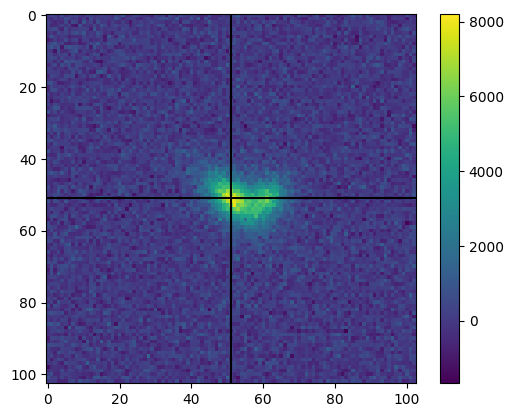

In [ ]:
plt.imshow(images[100, 0])
plt.colorbar()
# plt.axvline(40)
plt.axhline(103//2, c='k')
plt.axvline(103//2, c='k')

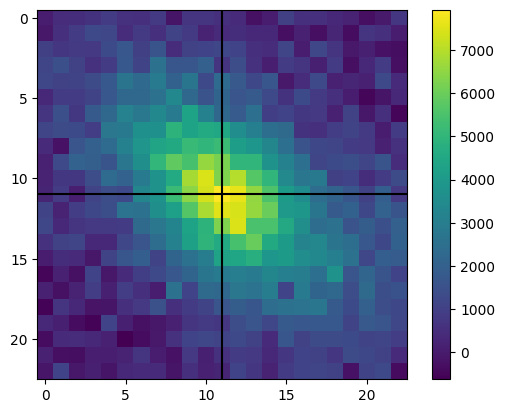

In [ ]:
#make sure image centered in pixel
crop = 40

plt.imshow(images[179, 0][crop:-crop, crop:-crop])
plt.colorbar()
# plt.axvline(40)
plt.axhline(23//2, c='k')
plt.axvline(23//2, c='k')


In [ ]:
n_source_probs, locs_mean, locs_sd = detection.forward(images.to(device))

tile_params = TileCatalog.from_flat_dict(tile_slen, 11, 11, 
                                         {'n_source_probs': n_source_probs.reshape(-1, 1).cpu(), 'locs': locs_mean.cpu(), 'locs_sd':locs_sd.cpu(), 'n_sources':n_source_probs.ge(0.1).cpu()})
full_cat_params = tile_params.to_full_params()

In [ ]:
full_cat_params['n_source_probs'].shape

torch.Size([200, 7, 1])

In [ ]:
n_source_probs = full_cat_params['n_source_probs'][:, :, 0]
n_source_probs[179]

tensor([0.1125, 0.1732, 0.9709, 0.5218, 0.1869, 0.1215, 0.0000])

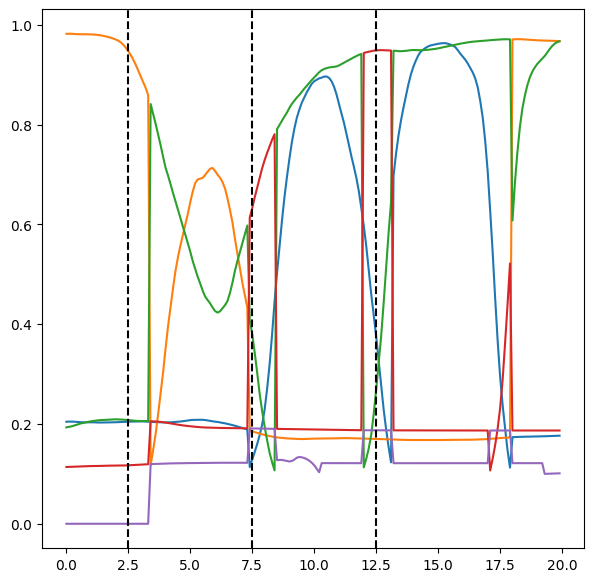

In [ ]:
plt.figure(figsize=(7,7))
n_source_probs = full_cat_params['n_source_probs'][:, :, 0]
for jj in range(5):
    probs = n_source_probs[:, jj]
    plt.plot(seps, probs)
plt.axvline(2.5, c='k', ls='--')
plt.axvline(7.5, c='k', ls='--')
plt.axvline(12.5, c='k', ls='--')

## True fluxes

In [ ]:
# calculate true fluxes via aperture photometry 
truth_res = get_residual_measurements(truth, images, paddings=torch.zeros_like(images),     
                                            sources=uncentered_true_sources)
truth_res.keys()

dict_keys(['flux', 'fluxerr', 'snr', 'ellips', 'sigma'])

In [ ]:
true_fluxes = truth_res['flux']
true_fluxes.shape

torch.Size([180, 2, 1])

## MAP fluxes

In [ ]:
# MAP
# do not include background!!!
# never out of tile in MAP


tile_cat_map = detection.variational_mode(images.to(device)).to('cpu')

tile_cat_map['galaxy_bools'] = rearrange(tile_cat_map.n_sources, 'b x y -> b x y 1')
tile_locs = tile_cat_map.locs.to(device)
_tile_gparams = deblender.variational_mode(images.to(device), tile_locs).to("cpu")
_tile_gparams *= tile_cat_map['galaxy_bools']
tile_cat_map['galaxy_params'] = _tile_gparams
cat_map = tile_cat_map.to_full_params()

_recon_uncentered = get_deblended_reconstructions(cat_map, deblender._dec, 
                                                slen=slen, device=deblender.device, batch_size=200)
map_res = get_residual_measurements(cat_map, images, 
                            paddings=torch.zeros_like(images), 
                            sources=_recon_uncentered,  )
map_fluxes = map_res['flux']
cat_map.plocs.shape, map_fluxes.shape

(torch.Size([180, 2, 2]), torch.Size([180, 2, 1]))

In [ ]:
true_plocs.shape

torch.Size([180, 2, 2])

In [ ]:
# match map fluxes
from bliss.reporting import match_by_locs

f1 = [] 
f2 = [] 

for jj in range(true_plocs.shape[0]): # len(seps)
    _tplocs = true_plocs[jj]
    _eplocs = cat_map.plocs[jj]
    tm, em, dkeep, _ = match_by_locs(_tplocs, _eplocs, slack=2)
    for kk in range(len(tm)):
        if dkeep[kk].item():
            if tm[kk] == 0: 
                f1.append(map_fluxes[jj][em[kk]].item())
            elif tm[kk] == 1:
                f2.append(map_fluxes[jj][em[kk]].item())
            else: 
                raise ValueError
        else: 
            if tm[kk] == 0:
                f1.append(0.)
            elif tm[kk] == 1:
                f2.append(0.)
            else: 
                raise ValueError

f1_map = torch.tensor(f1)
f2_map = torch.tensor(f2)

f1_map.shape, f2_map.shape

(torch.Size([180]), torch.Size([180]))

In [ ]:
tm, em

(array([0, 1]), array([0, 1]))

In [ ]:
cat_map.plocs[10]

tensor([[27.6053, 28.0158],
        [ 0.0000,  0.0000]])

In [ ]:
seps[50]

tensor(5.)

In [ ]:
true_plocs[50]

tensor([[27.5000, 27.5000],
        [27.5000, 32.5000]])

In [ ]:
cat_map.plocs[60]

tensor([[27.5926, 32.0557],
        [27.3052, 27.8837]])

In [ ]:
true_fluxes.shape

torch.Size([180, 2, 1])

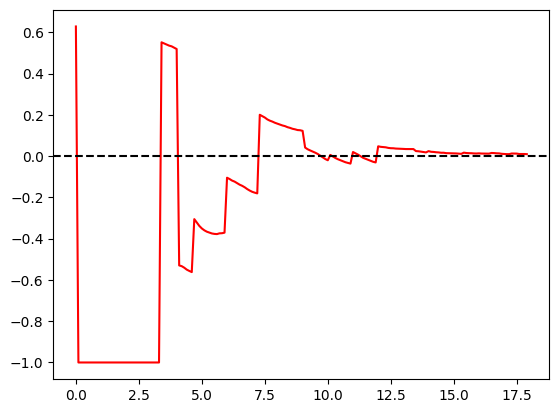

In [ ]:
y = (f1_map - true_fluxes[:, 0, 0])/ true_fluxes[:, 0, 0]
plt.plot(seps, y, 'r')
plt.axhline(0.0, color='k', linestyle='--')

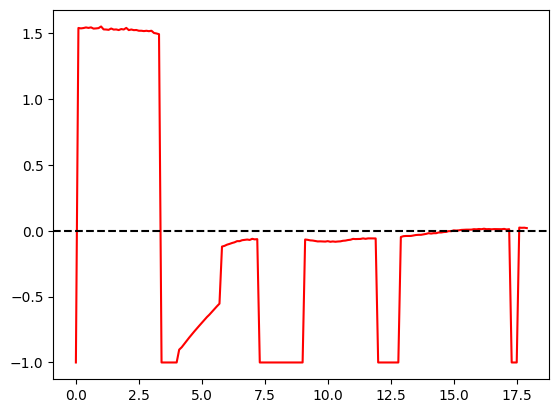

In [ ]:
y = (f2_map - true_fluxes[:, 1, 0]) / true_fluxes[:, 1, 0]
plt.plot(seps, y, 'r')
plt.axhline(0.0, color='k', linestyle='--')

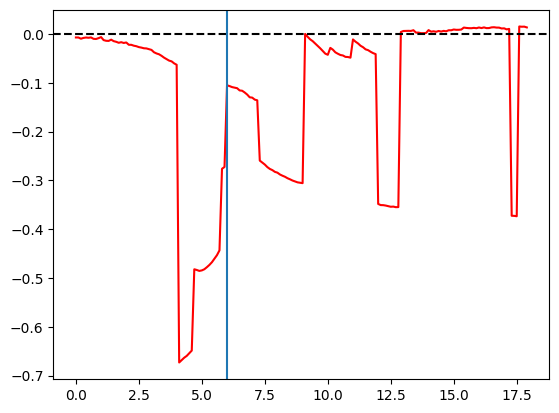

In [ ]:
y1 = f1_map + f2_map
y2 = true_fluxes[:, 0, 0] + true_fluxes[:, 1, 0]
y = (y1 - y2)  / y2
plt.plot(seps, y, 'r')
plt.axhline(0.0, color='k', linestyle='--')
plt.axvline(6.0,)

## Samples fluxes

In [ ]:
samples = detection.sample(images.to(device), n_samples=200)
samples = {k:v.to('cpu') for k,v in samples.items()}

tensor([0.0591])


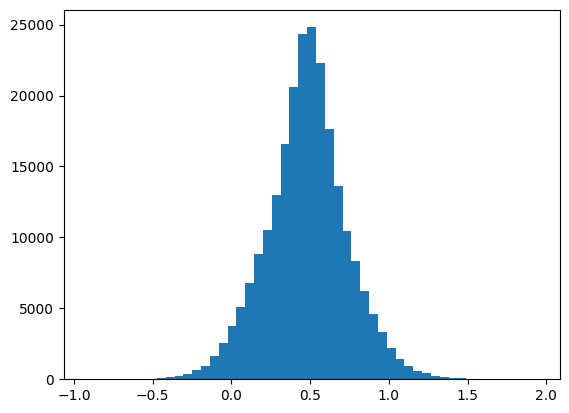

In [ ]:
# how many fall out of distribution??
_locs = samples['locs'].flatten()
nonzero_locs = _locs[_locs.nonzero()]

_ = plt.hist(nonzero_locs, bins=51)


total_out = sum(nonzero_locs < 0) + sum(nonzero_locs > 1)
print(total_out / len(nonzero_locs)) # ~ 5%


In [ ]:
# # trim samples of locs with some tolerance
# mask = samples['locs'] != 0.0
# new_locs = samples['locs'].clamp(min=0.001, max=1.0-0.001) * mask.float()

In [ ]:
# mask out samples out of boundaries
mask_xy = samples['locs'].ge(0.0001) * samples['locs'].le(1-0.0001)
mask = mask_xy[...,0].bitwise_and(mask_xy[...,1])
new_locs = samples['locs'] * rearrange(mask, 'n nt -> n nt 1')
new_n_sources = samples['n_sources'] * mask

In [ ]:
sum(new_n_sources.flatten()), sum(samples['n_sources'].flatten())

(tensor(103678.), tensor(116975.))

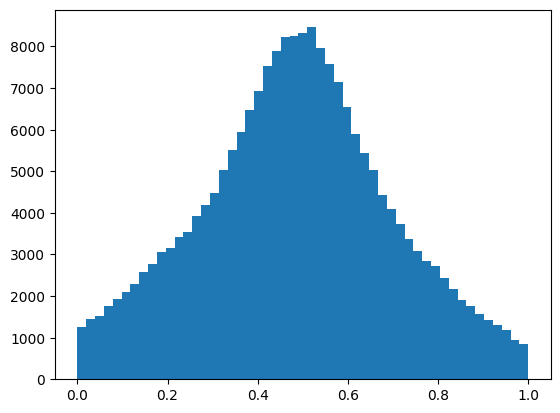

In [ ]:
_locs = new_locs.flatten()
nonzero_locs = _locs[_locs.nonzero()]

_ = plt.hist(nonzero_locs, bins=51)

In [ ]:
new_samples = {**samples}
new_samples['n_sources'] = new_n_sources
new_samples['locs'] = new_locs

In [ ]:
# get catalogs
tile_cats = [] 
cats = [] 
n_samples = 100
for ii in range(n_samples): 
    tile_cat = TileCatalog.from_flat_dict(tile_slen, 11, 11, {k:v[ii] 
                                                              for k,v in new_samples.items()})
    cat = tile_cat.to_full_params()
    cats.append(cat)

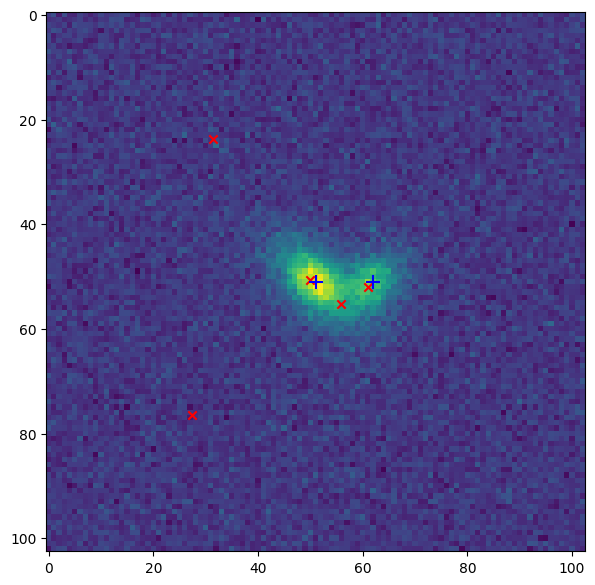

In [ ]:
plt.figure(figsize=(7,7))

ii = 110
jj = np.random.randint(0, 100)
plt.imshow(images[ii, 0])

_plocs = cats[jj].plocs
for kk in range(len(_plocs[ii])):
    x, y = _plocs[ii, kk, 1].item(), _plocs[ii, kk, 0].item()
    if x > 0 and y > 0:
        plt.scatter(x+bp-0.5, y+bp-0.5, marker='x', color='r')

plt.scatter(true_plocs[ii, :, 1] + bp - 0.5, true_plocs[ii, :, 0] + bp - 0.5, marker='+', color='b', s=100, )

In [ ]:
# we need to do some sort of matching for the galaxy we are targeting
all_fluxes = []
for cat in tqdm(cats, total=len(cats)): 

     tile_cat = cat.to_tile_params(tile_slen)
     tile_cat['galaxy_bools'] = rearrange(tile_cat.n_sources, 'b x y -> b x y 1')
     tile_locs = tile_cat.locs.to(device)
     _tile_gparams = deblender.variational_mode(images.to(device), tile_locs).to("cpu")
     _tile_gparams *= tile_cat['galaxy_bools']
     tile_cat['galaxy_params'] = _tile_gparams
     new_cat = tile_cat.to_full_params()

     recon_uncentered = get_deblended_reconstructions(new_cat, deblender._dec, 
                                                      slen=slen, device=deblender.device, batch_size=200)
     _res = get_residual_measurements(new_cat, images, 
                                   paddings=torch.zeros_like(images), sources=recon_uncentered,  )
     all_fluxes.append(_res['flux'])

# max_n_fluxes = max(f.shape[1] for f in fluxes)
# all_the_fluxes = torch.zeros(100, 180, max_n_fluxes, 1)
# for ii, fs in enumerate(fluxes):
#      all_the_fluxes[]


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [06:48<00:00,  4.08s/it]


In [ ]:
from bliss.reporting import match_by_locs

f1s = [] 
f2s = [] 

for ii in tqdm(range(len(cats))): # read: samples
    f1 = []
    f2 = []
    for jj in range(true_plocs.shape[0]):
        _tplocs = true_plocs[jj]
        _eplocs = cats[ii].plocs[jj]
        tm, em, dkeep, _ = match_by_locs(_tplocs, _eplocs, slack=2) # example: HSC -> 3 pixels for matching (Yr3 Li et al. ~2021)
        for kk in range(len(tm)):
            if dkeep[kk].item():
                if tm[kk] == 0: 
                    f1.append(all_fluxes[ii][jj][em[kk]].item())
                elif tm[kk] == 1:
                    f2.append(all_fluxes[ii][jj][em[kk]].item())
                else: 
                    raise ValueError
            else: 
                if tm[kk] == 0:
                    f1.append(np.nan)
                elif tm[kk] == 1:
                    f2.append(np.nan)
                else: 
                    raise ValueError
    f1s.append(torch.tensor(f1))
    f2s.append(torch.tensor(f2))

f1s = torch.stack(f1s)
f2s = torch.stack(f2s)

f1s.shape, f2s.shape

100%|██████████| 100/100 [00:07<00:00, 14.17it/s]


(torch.Size([100, 180]), torch.Size([100, 180]))

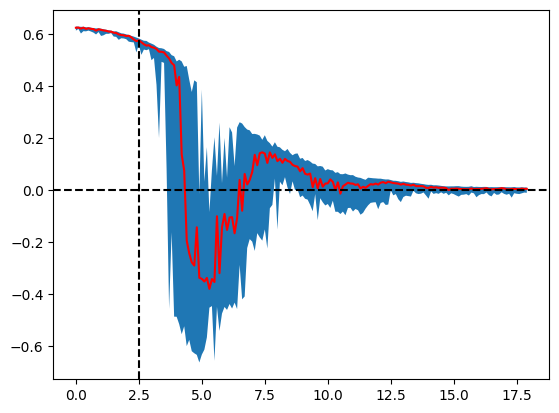

In [ ]:
y = (f1s.nanquantile(0.5, axis=0) - true_fluxes[:, 0, 0]) / true_fluxes[:, 0, 0]
y1  = (f1s.nanquantile(0.159, axis=0) - true_fluxes[:, 0, 0]) / true_fluxes[:, 0, 0]
y2 = (f1s.nanquantile(0.841, axis=0) - true_fluxes[:, 0, 0]) / true_fluxes[:, 0, 0]

plt.plot(seps, y, 'r')
plt.fill_between(seps, y1, y2)
plt.axhline(0.0, color='k', linestyle='--')
plt.axvline(2.5, color='k', linestyle='--')

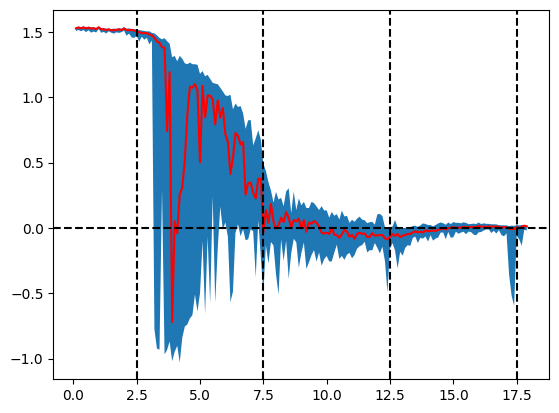

In [ ]:
y = (f2s.nanquantile(0.5, axis=0) - true_fluxes[:, 1, 0]) / true_fluxes[:, 1, 0]
y1  = (f2s.nanquantile(0.159, axis=0) - true_fluxes[:, 1, 0]) / true_fluxes[:, 1, 0]
y2 = (f2s.nanquantile(0.841, axis=0) - true_fluxes[:, 1, 0]) / true_fluxes[:, 1, 0]

plt.plot(seps, y, 'r')
plt.fill_between(seps, y1, y2)
plt.axhline(0.0, color='k', linestyle='--')
plt.axvline(2.5, color='k', linestyle='--')
plt.axvline(7.5, color='k', linestyle='--')
plt.axvline(12.5, color='k', linestyle='--')
plt.axvline(17.5, color='k', linestyle='--')

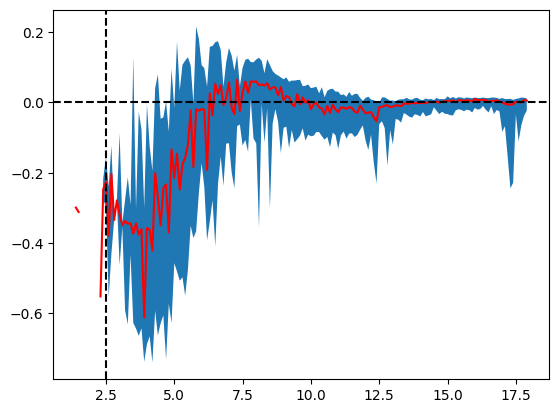

In [ ]:
# total flux
fs = f1s + f2s
tf = true_fluxes[:, 0, 0] + true_fluxes[:, 1, 0]

y = (fs.nanquantile(0.5, axis=0) - tf) / tf
y1 = (fs.nanquantile(0.159, axis=0) - tf) / tf
y2 = (fs.nanquantile(0.841, axis=0) - tf) / tf

plt.plot(seps, y, 'r')
plt.fill_between(seps, y1, y2)
plt.axhline(0.0, color='k', linestyle='--')
plt.axvline(2.5, color='k', linestyle='--')